<a href="https://colab.research.google.com/github/MatteoGhizzi/MLPNS2021/blob/main/LEZ20_Autoencode_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense#, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import glob
import pylab as pl
from PIL import Image

%pylab inline

Populating the interactive namespace from numpy and matplotlib


go to runtime -> change runtime type -> GPU

(60000, 28, 28)

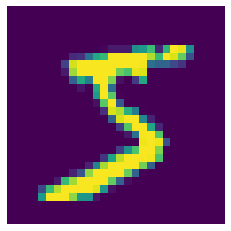

In [2]:
from keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

img_rows, img_cols = 28, 28
pl.imshow(x_train[0])
pl.axis('off')
intialshape = x_train[0].shape
ndim = np.prod(x_train[0].shape)
x_train.shape

In [3]:
x_train.dtype, x_train.max(), x_train.min()

(dtype('uint8'), 255, 0)

#importante:

è necessario rinormalizzare le figure in modo da avere valori tra 0 e 1: è obbligatorio nei neural networks

In [4]:
x_train = (x_train.astype(float) / 255).reshape(len(x_train), ndim)
x_test = (x_test.astype(float) / 255).reshape(len(x_test), ndim)
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [5]:
keras.models?

In [6]:
model_digits64 = Sequential()
## encoder
# input layer and the output size
model_digits64.add(Dense( units= 128, activation='relu', input_dim = ndim))
  #compression layer
model_digits64.add(Dense(units = 64, activation='relu'))
## deencoder
#decompression layer, same size as in the encoder
model_digits64.add(Dense(units = 128, activation='relu'))
#output layer, same size as input
model_digits64.add(Dense(ndim, activation='linear'))


#alternative syntax
"""
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
"""

'\nencoded = Dense(encoding_dim, activation=\'relu\')(input_img)\n# "decoded" is the lossy reconstruction of the input\ndecoded = Dense(784, activation=\'sigmoid\')(encoded)\n\nautoencoder = Model(input_img, decoded)\n\nencoder = Model(input_img, encoded)\n\n# create a placeholder for an encoded (32-dimensional) input\nencoded_input = Input(shape=(encoding_dim,))\n# retrieve the last layer of the autoencoder model\ndecoder_layer = autoencoder.layers[-1]\n# create the decoder model\ndecoder = Model(encoded_input, decoder_layer(encoded_input))\n'

In [7]:
# da dare ll'optimazer model.compile(optimizer =keras.optimizers.Adam(lr=0.05))


In [8]:
model_digits64.compile(optimizer = keras.optimizers.Adam(lr=0.01), loss='mean_squared_error')
#model_digits64.compile(optimizer="adadelta", loss="mean_squared_error")

In [9]:
print(model_digits64.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               101136    
Total params: 218,192
Trainable params: 218,192
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
history64 = model_digits64.fit(x_train, x_train, 
                               validation_data=(x_test, x_test),
                               epochs=60, batch_size=100, verbose=1)

Epoch 1/60
600/600 [==============================] - 3s 3ms/step - loss: 0.0413 - val_loss: 0.0263
Epoch 2/60
600/600 [==============================] - 1s 2ms/step - loss: 0.0261 - val_loss: 0.0242
Epoch 3/60
600/600 [==============================] - 1s 2ms/step - loss: 0.0244 - val_loss: 0.0234
Epoch 4/60
600/600 [==============================] - 1s 2ms/step - loss: 0.0237 - val_loss: 0.0227
Epoch 5/60
600/600 [==============================] - 1s 2ms/step - loss: 0.0231 - val_loss: 0.0225
Epoch 6/60
600/600 [==============================] - 1s 2ms/step - loss: 0.0229 - val_loss: 0.0223
Epoch 7/60
600/600 [==============================] - 1s 2ms/step - loss: 0.0225 - val_loss: 0.0218
Epoch 8/60
600/600 [==============================] - 1s 2ms/step - loss: 0.0225 - val_loss: 0.0228
Epoch 9/60
600/600 [==============================] - 1s 2ms/step - loss: 0.0224 - val_loss: 0.0216
Epoch 10/60
600/600 [==============================] - 1s 2ms/step - loss: 0.0223 - val_loss: 0.0221

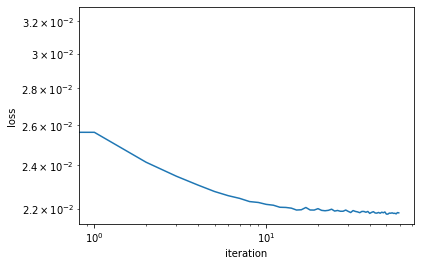

In [11]:
pl.plot(np.array(history64.history['loss']))
pl.ylabel('loss')
pl.xlabel('iteration')
pl.yscale('log')
pl.xscale('log')

In [12]:
model_digits64.compile?

In [13]:
output_image64 = model_digits64.predict(x_test)

In [14]:
def compareinout(i, outim, testimg, initialshape=(28,28)):
  fig = pl.figure(figsize(10,5))
  ax = fig.add_subplot(121) 
  ax.imshow(testimg[i].reshape(initialshape) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(122) 
  ax.imshow(outim[i].reshape(initialshape) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

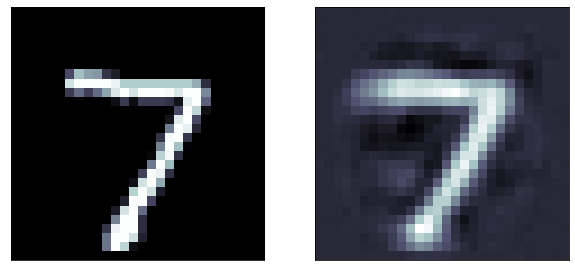

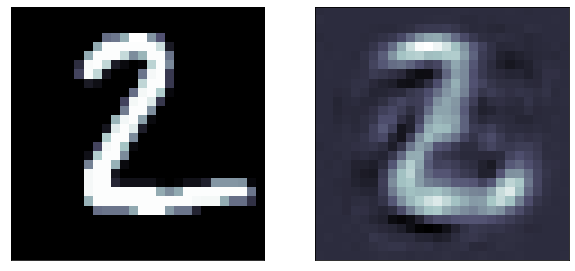

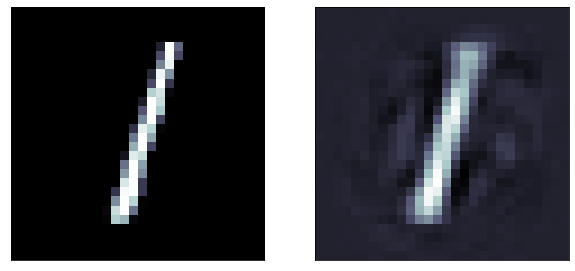

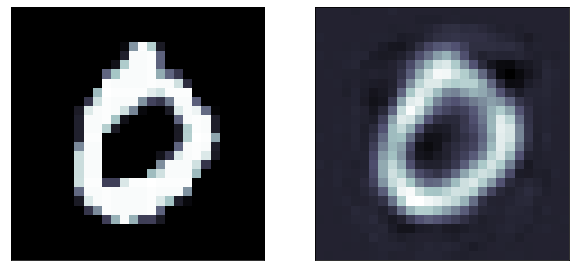

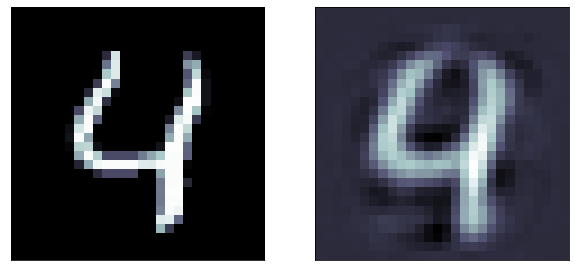

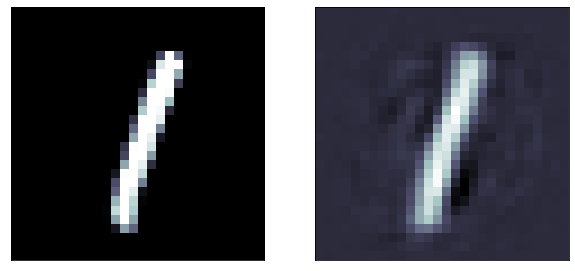

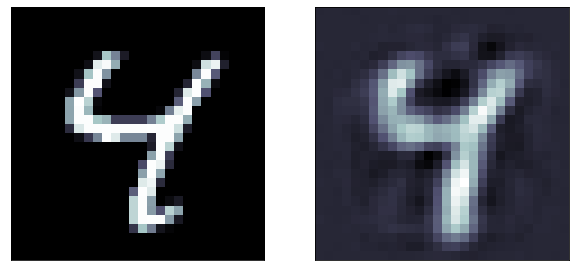

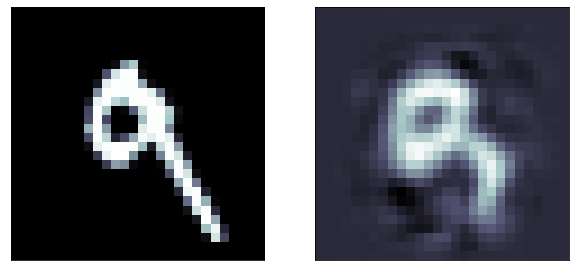

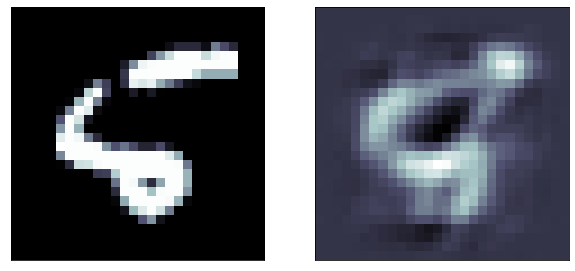

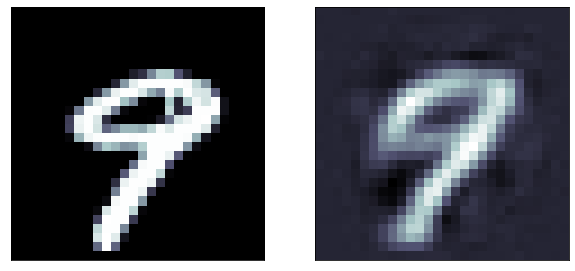

In [15]:
for i in range(10):
  compareinout(i, output_image64, x_test)

il risultato non è soddisfacente e le figure sono troppo dettagliate.

Una possibile soluzione al problema potrebbe essere modificare l'ultima funzione di attivazione, proviamo con una sigmoide

In [16]:
# choose the optimizer and loss appropriately!
model_digits64_sig = Sequential()
## encoder
# input layer and the output size
model_digits64_sig.add(Dense(128, activation='relu', input_dim=ndim))
#compression layer
model_digits64_sig.add(Dense(64, activation='relu'))
## deencoder
#decompression layer, same size as in the encoder
model_digits64_sig.add(Dense(128, activation='relu'))
#output layer, same size as input
model_digits64_sig.add(Dense(ndim, activation='sigmoid'))
model_digits64_sig.compile(optimizer= keras.optimizers.Adam(lr=0.005), loss="mean_squared_error") #binary_cross_entropy)

In [17]:
history64_sig = model_digits64_sig.fit(x_train, x_train, 
                                       validation_data=(x_test, x_test), 
                                       epochs=100, batch_size=100, verbose=1)

Epoch 1/100
600/600 [==============================] - 2s 3ms/step - loss: 0.0446 - val_loss: 0.0116
Epoch 2/100
600/600 [==============================] - 1s 2ms/step - loss: 0.0110 - val_loss: 0.0085
Epoch 3/100
600/600 [==============================] - 1s 2ms/step - loss: 0.0085 - val_loss: 0.0075
Epoch 4/100
600/600 [==============================] - 1s 2ms/step - loss: 0.0075 - val_loss: 0.0069
Epoch 5/100
600/600 [==============================] - 1s 2ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 6/100
600/600 [==============================] - 1s 2ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 7/100
600/600 [==============================] - 1s 2ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 8/100
600/600 [==============================] - 1s 2ms/step - loss: 0.0063 - val_loss: 0.0059
Epoch 9/100
600/600 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 10/100
600/600 [==============================] - 1s 2ms/step - loss: 0.0061 - val_lo

Text(0.5, 0, 'iteration')

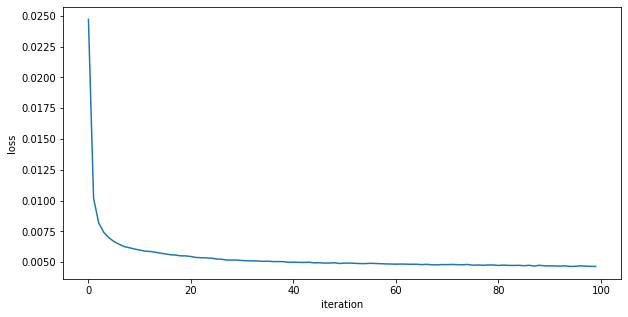

In [18]:
pl.plot(np.array(history64_sig.history['loss']))
pl.ylabel('loss')
pl.xlabel('iteration')
#pl.yscale('log')
#pl.xscale('log')

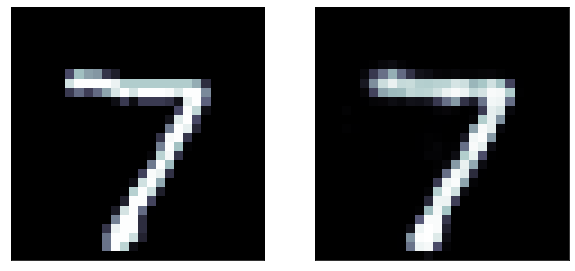

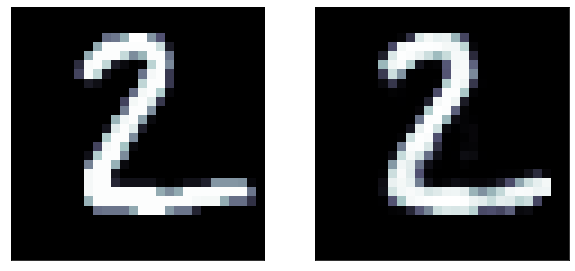

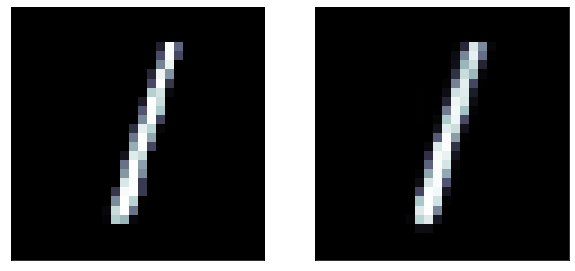

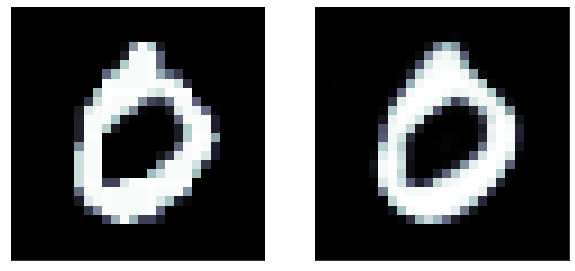

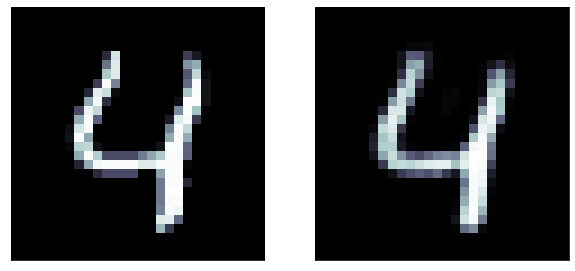

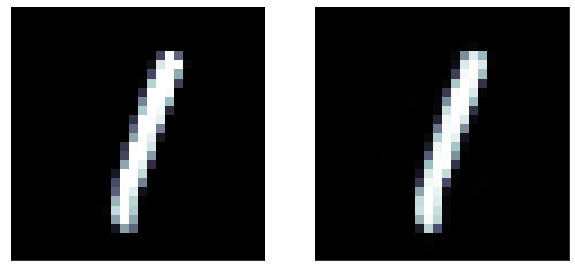

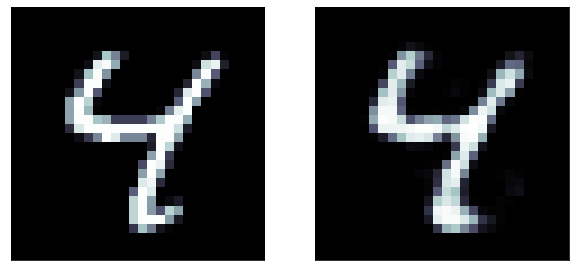

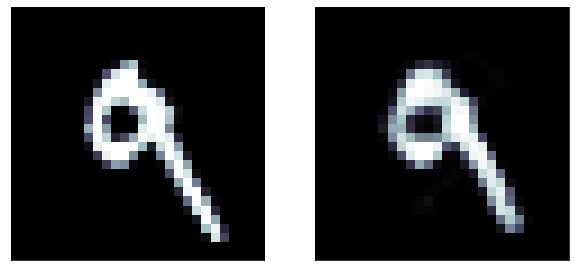

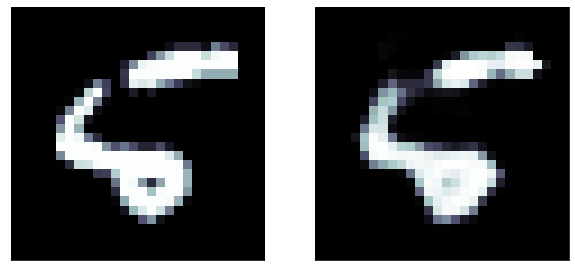

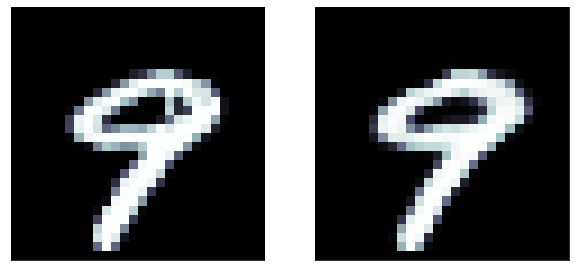

In [19]:
output_image64_sig = model_digits64_sig.predict(x_test)
for i in range(10):
  compareinout(i, output_image64_sig, x_test)

scegliamo una loss function più adeguata ad un non-binary classification

In [20]:
# sigmoid and binary cross entropy loss
model_digits64_bce = model_digits64_sig

In [21]:
model_digits64_bce.compile(optimizer= "adadelta", loss="binary_crossentropy") #binary_cross_entropy)

In [22]:
history64_bce = model_digits64_bce.fit(x_train, x_train, 
                                       validation_data=(x_test, x_test), 
                                       epochs=50, batch_size=100, verbose=1)

Epoch 1/50
600/600 [==============================] - 2s 3ms/step - loss: 0.0768 - val_loss: 0.0756
Epoch 2/50
600/600 [==============================] - 1s 2ms/step - loss: 0.0757 - val_loss: 0.0754
Epoch 3/50
600/600 [==============================] - 1s 2ms/step - loss: 0.0756 - val_loss: 0.0753
Epoch 4/50
600/600 [==============================] - 1s 2ms/step - loss: 0.0758 - val_loss: 0.0752
Epoch 5/50
600/600 [==============================] - 1s 2ms/step - loss: 0.0756 - val_loss: 0.0752
Epoch 6/50
600/600 [==============================] - 1s 2ms/step - loss: 0.0755 - val_loss: 0.0751
Epoch 7/50
600/600 [==============================] - 1s 2ms/step - loss: 0.0754 - val_loss: 0.0751
Epoch 8/50
600/600 [==============================] - 1s 2ms/step - loss: 0.0753 - val_loss: 0.0751
Epoch 9/50
600/600 [==============================] - 1s 2ms/step - loss: 0.0754 - val_loss: 0.0750
Epoch 10/50
600/600 [==============================] - 1s 2ms/step - loss: 0.0754 - val_loss: 0.0750

Text(0.5, 0, 'iteration')

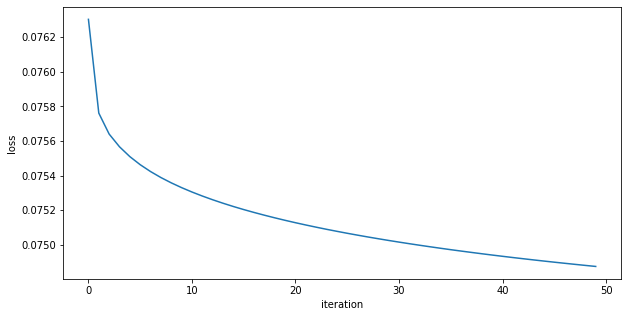

In [23]:
pl.plot(np.array(history64_bce.history['loss']))
pl.ylabel('loss')
pl.xlabel('iteration')
#pl.yscale('log')
#pl.xscale('log')

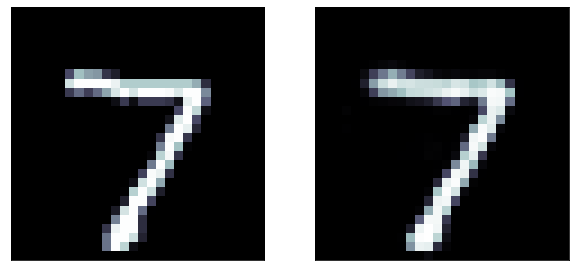

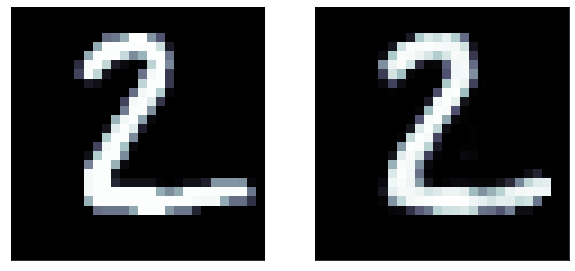

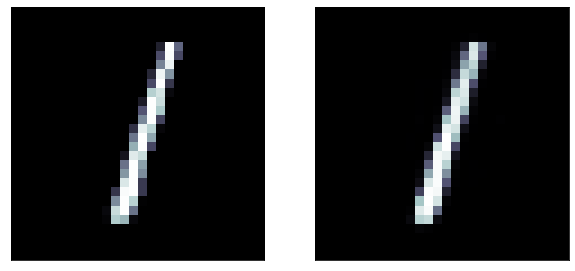

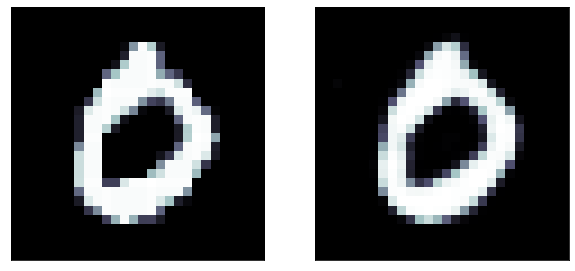

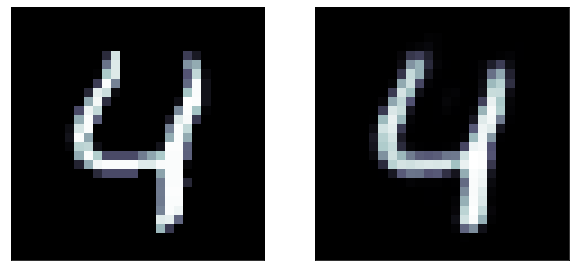

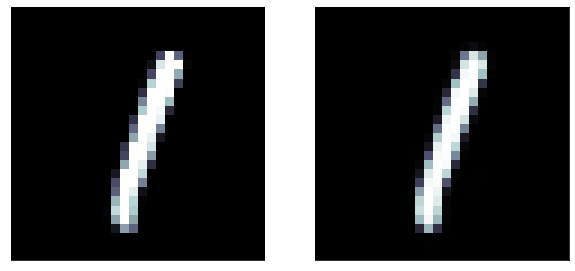

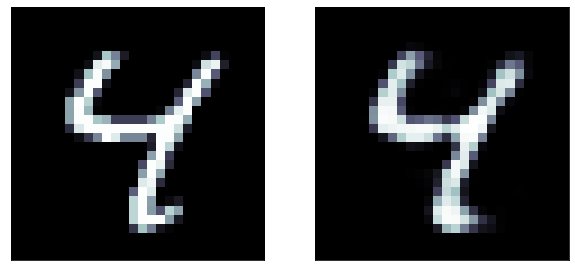

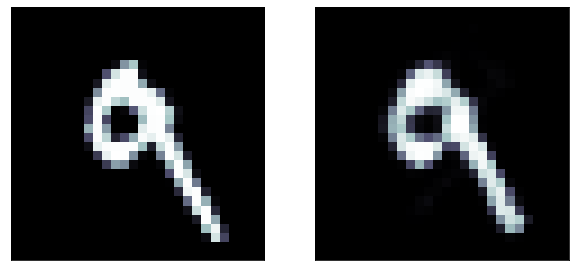

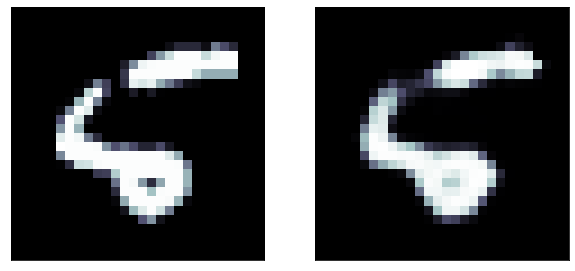

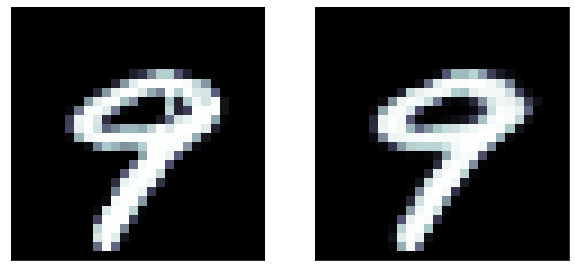

In [24]:
output_image64_bce = model_digits64_bce.predict(x_test)
for i in range(10):
  compareinout(i, output_image64_bce, x_test)

risultato abbastanza soddisfacente!!!

Text(0.5, 1.0, 'the 3 loss functions, log scale')

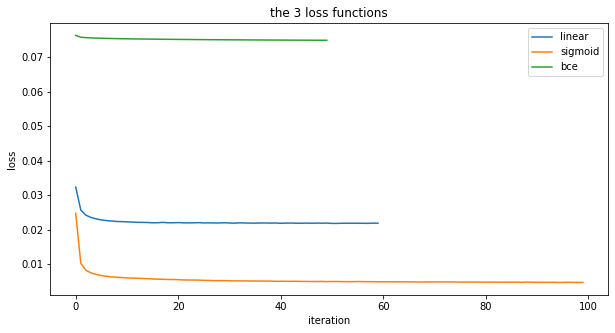

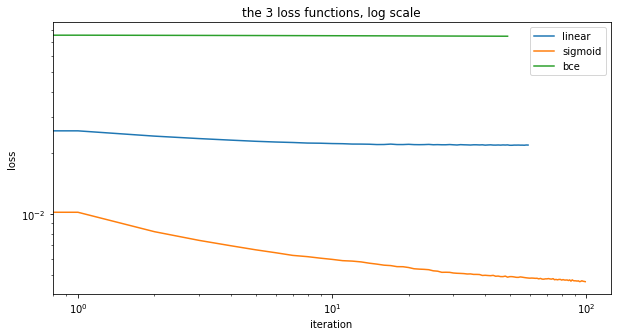

In [25]:
pl.plot(np.array(history64.history['loss']), label="linear")
pl.plot(np.array(history64_sig.history['loss']), label="sigmoid")
pl.plot(np.array(history64_bce.history['loss']), label="bce")
pl.ylabel('loss')
pl.xlabel('iteration')
pl.legend()
pl.title("the 3 loss functions")
pl.figure()
pl.plot(np.array(history64.history['loss']), label="linear")
pl.plot(np.array(history64_sig.history['loss']), label="sigmoid")
pl.plot(np.array(history64_bce.history['loss']), label="bce")
pl.ylabel('loss')
pl.xlabel('iteration')
pl.xscale('log')
pl.yscale('log')
pl.legend()
pl.title("the 3 loss functions, log scale")